<a href="https://colab.research.google.com/github/markotesic/Robust-Evaluation-of-Generative-AI/blob/main/notebooks/2_1_IntroductionToMeasurementLayouts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to the Measurement Layout Framework: Part 1

Here we implement the measurement layouts framework in PyMC. In this tutorial, for simplicity, we will use a synthetic dataset, but in later sessions, we will work with real AI systems.

This synthetic dataset will mimic performance on tasks in the [Massive Multitask Language Understanding (MMLU)](https://arxiv.org/pdf/2009.03300) benchmark designed to test LLMs' world knowledge and problem-solving abilities across 57 domains. Here we focus on one domain (econometrics). We will see how LLMs with similar performance in the domain can have different domain capabilities.

In general, to build measurement layouts from LLMs' performance on benchmark data we need:

- Instance-level data, i.e., whether the LLM succeeded or not on each instance in the benchmark.
- Meta-features or demands: these describe how the benchmark was built and any features that were explicitly manipulated.
- Information on what capabilities are being tested in the benchmark (and how they relate to each other).

If you would like to save any changes you make to the colab, make sure to save a copy to your Google Drive!


In [1]:
! pip install 'pymc>5.9' --quiet
! pip install 'numpyro' --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 5.8 MB/s eta 0:00:00


In [2]:
import pymc as pm
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve
import arviz as az
import random as rm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import graphviz
sns.set(style="whitegrid")
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.10.4


## Useful functions

In [3]:
def logistic_general(x, min, max, c = 0, p = 0.99):

  """
  Generalized version of the logistic where min can be any number, not just 0 as above.

  :param min: The min ability/demand
  :param max: The max ability/demand
  :param c: Set different from 0 when we are dealing with multiple choice responses; e.g. c is 0.5 when the response is yes/no, and c is 0.25 if there are 4 possible choices
  :param p: The probability we want to set the max margin to (e.g. 0.99 or 0.999); the min margin will be set to 1 - p
  :parm k: The slope of the logistic
  """
  max_n = max - min
  k = - np.log((1 - p)/(p - c)) / max_n
  return c + ((1 - c) / (1 + np.exp(-k * x)))

def margin(ability, demand):
  """
  Calculate the margin
  """
  return ability - demand

def binary_margin(ability, demand):
  """
  Calculate the margin when demands are binary.
  """
  return ability - np.log(demand + 0.00001)

def process_predictive_data_and_plot_histogram(predictive_data, predictive_type:str,performance_var_name:str,LLM=pd.NA):
  """
  Plot prior and posterior predictive.
  """
  # Convert to DataFrames and calculate mean directly
  if predictive_type == 'prior':
      predictive_mean = predictive_data.prior_predictive[performance_var_name].to_dataframe().groupby('draw').mean()
  elif predictive_type == 'posterior':
      predictive_mean = predictive_data.posterior_predictive[performance_var_name].to_dataframe().groupby('draw').mean()
  else:
      raise ValueError("predictive_type must be 'prior' or 'posterior'")

  # Get observed
  observed = predictive_data.observed_data.to_dataframe().mean().values[0]

  # Get simulated mean
  simulated_mean = predictive_mean[performance_var_name].mean()


  # Plotting
  plt.figure(figsize=(8, 6))
  # Histogram of predictive means
  sns.histplot(predictive_mean[performance_var_name], kde=True, stat='density', edgecolor='black', bins=20) #color='skyblue'

  #Vertical line for observed data
  plt.axvline(x=observed, color='red', linestyle='--', linewidth=2, label='Observed')
  #Vertical line for the mean of simulated data
  plt.axvline(x=simulated_mean, color='blue', linestyle='-', linewidth=2, label='Simulated')


  plt.xlabel(performance_var_name)
  plt.ylabel('Density')
  plt.title(f'{predictive_type.capitalize()} Predictive Task Performance Distribution: {LLM}')
  plt.legend()
  plt.xlim(0, 1)
  plt.show()

### Plot the logistic function

The logistic below will assign probability $p$ to whatever the max margin is set to using max and min ranage. This then sets the slope of that logistic.

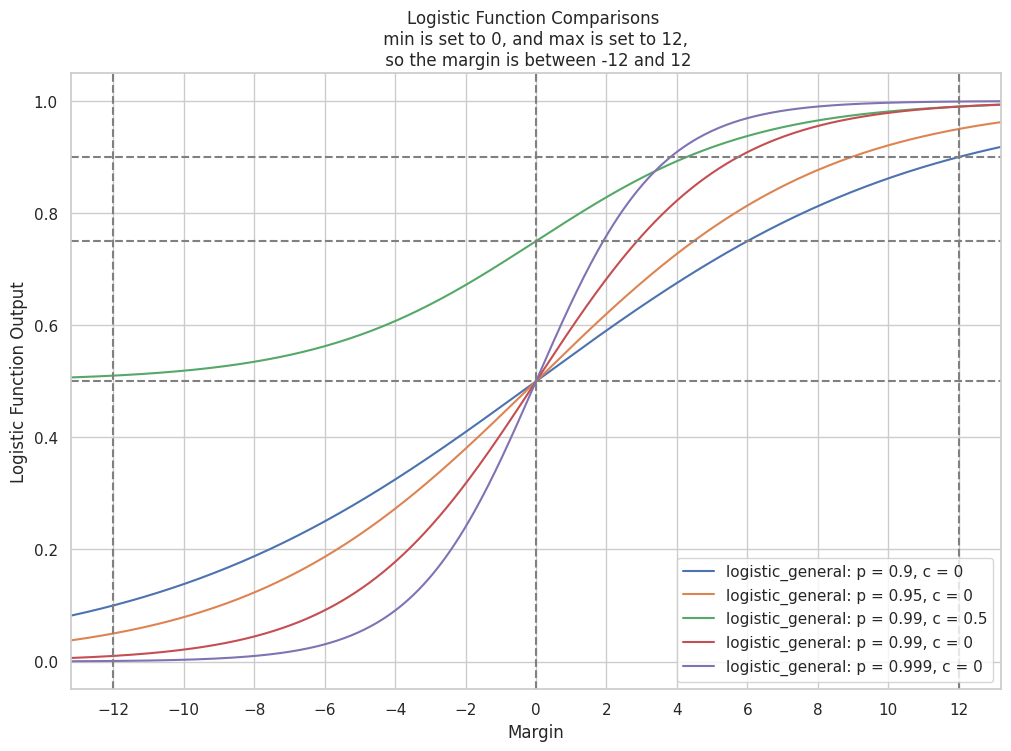

In [4]:
#can change the range of demands/capabilities
min_d = 0
max_d = 12

min_margin = min_d - max_d
max_margin = max_d - min_d

x_values = np.linspace(min_margin + min_margin * 0.1, max_margin + max_margin * 0.1, 400)
y_multichoice_9 = logistic_general(x_values,min=min_d,max=max_d,c=0,p=0.9)
y_multichoice_95 = logistic_general(x_values,min=min_d,max=max_d,c=0,p=0.95)
y_multichoice_99 = logistic_general(x_values,min=min_d,max=max_d,c=0,p=0.99)
y_multichoice_99c = logistic_general(x_values,min=min_d,max=max_d,c=0.5,p=0.99)
y_multichoice_999 = logistic_general(x_values,min=min_d,max=max_d,c=0,p=0.999)

ticks = np.linspace(min_margin, max_margin, 13)

plt.figure(figsize=(12, 8))

sns.lineplot(x=x_values, y=y_multichoice_9, label='logistic_general: p = 0.9, c = 0')
sns.lineplot(x=x_values, y=y_multichoice_95, label='logistic_general: p = 0.95, c = 0')
sns.lineplot(x=x_values, y=y_multichoice_99c, label='logistic_general: p = 0.99, c = 0.5')
sns.lineplot(x=x_values, y=y_multichoice_99, label='logistic_general: p = 0.99, c = 0')
sns.lineplot(x=x_values, y=y_multichoice_999, label='logistic_general: p = 0.999, c = 0')

plt.xlim(min_margin + min_margin * 0.1, max_margin + max_margin * 0.1)

plt.axhline(0.5, color='gray', linestyle='--')  # Horizontal line at y=0.5
plt.axhline(0.75, color='gray', linestyle='--')
plt.axhline(0.9, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.axvline(min_d - max_d, color='gray', linestyle='--')
plt.axvline(max_d - min_d, color='gray', linestyle='--')

plt.xticks(ticks)

plt.title(f'Logistic Function Comparisons \n min is set to {min_d}, and max is set to {max_d}, \n so the margin is between {min_margin} and {max_margin}')
plt.xlabel('Margin')
plt.ylabel('Logistic Function Output')
plt.legend()
plt.show()


## Exercise 1.1

### Load data

In [5]:
ex2_1_training_data = pd.read_csv("https://raw.githubusercontent.com/markotesic/Robust-Evaluation-of-Generative-AI/main/data/ex2_1_training_data.csv")
ex2_1_test_data = pd.read_csv("https://raw.githubusercontent.com/markotesic/Robust-Evaluation-of-Generative-AI/main/data/ex2_1_test_data.csv")

### Explore data

In [6]:
ex2_1_training_data.head()

,llm1_success,llm2_success,llm3_success,econometrics_difficulty
0,0,0,0,7
1,0,0,0,6
2,0,0,0,6
3,0,0,1,1
4,0,1,1,2


In [7]:
ex2_1_training_data.describe()

,llm1_success,llm2_success,llm3_success,econometrics_difficulty
count,5000.000000,5000.000000,5000.000000,5000.00000
mean,0.100800,0.223400,0.226200,3.95960
std,0.301094,0.416566,0.418412,1.97655
min,0.000000,0.000000,0.000000,1.00000
25%,0.000000,0.000000,0.000000,2.00000
50%,0.000000,0.000000,0.000000,4.00000
75%,0.000000,0.000000,0.000000,6.00000
max,1.000000,1.000000,1.000000,7.00000


<Axes: >

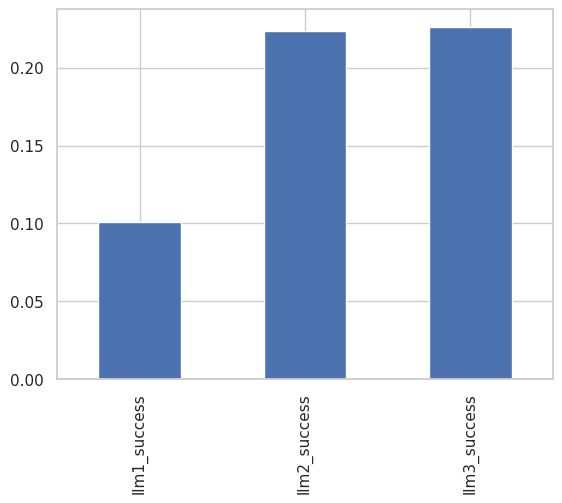

In [8]:
mean_values = ex2_1_training_data.drop('econometrics_difficulty',axis=1).mean()
mean_values.plot(kind='bar')

As you can see, we have a dataframe of 5000 task instances and performance data for three LLMs. Each instance was labeled with respect to its econometrics difficulty (which in this case ranges from 1 to 7).

We can also see that LLM1 succeeded on about 10% of the instances, and LLM2 and LLM3 succeeded on about 22% of the instances.

### A simple Measurement Layout

Let's create a simple measurement layout for one LLM where the meta-feature, econometrics difficulty, affects the LLM's performance.

Before we start implementing our model in PyMC, we need to determine the meta-features, capabilities, and linking functions as we wish to express them in the Measurement Layouts framework.

Clearly there is going to be one meta-feature, econometrics difficulty, and one capability, econometrics ability.

There will also be one performance node, again, econometrics ability, which in this simple case correponds to the final observed performance.

The most important parts to specify are the linking functions. How does partial performance depend on capabilities and meta-features?

In this model we will make the assumption that economerics performance depends simply on how difficult the econometrics questions are. That is, on the margin of navigation ability and distance:

$$econometricsP = \sigma(econometricsAbility - econometricsDemand)$$

The greater econometricsAbility is relative to the econometricsDemand, the more likely the agent is to succeed on the task. When the two are equal, a probability of success of 0.5 is yielded.

The observedPerformance is the dependent on this econometricsP.

In [12]:
def setupModel(relevantData,llm:str):

  m_ex1 = pm.Model()

  with  m_ex1:
    #demands
    econometricsDemand = pm.MutableData("econometricsDemand", relevantData["econometrics_difficulty"])

    #abilities
    econometricsAbility = pm.Normal("econometricsAbility", mu = 0, sigma = 4)

    #local performance
    econometricsP = pm.Deterministic("econometricsP", logistic_general(margin(econometricsAbility,econometricsDemand),min=1,max=7*1.2,c=0,p=0.99))

    observed = pm.Bernoulli("ObservedPerformance", econometricsP, observed =relevantData[llm+'_success'])

  return m_ex1


Instantiate the the model and specify model components.

In [11]:
llm = 'llm2'
m_ex1 = setupModel(ex2_1_training_data,llm=llm)

### Model Recap

Let's quickly recap what this model is doing.

First, we instantiate a new model, `m_ex1`, using standard PyMC notation `pm.Model()`.
Within that model, i.e. everything after `with m_ex1`, we define a MutableData variable to represent the distance metafeatures. For now, don't worry about why it's MutableData; this will become apparent later on in the tutorial. We then give the PyMC variable a label for PyMC to use to identify our variable `econometricsDemand`. We also provide the list of `econometrics_difficulty` values from the dataframe.

Second, we create a capability for econometrics, which we call `econometricsAbility`. We assume that the capability priors are normally distributed. We want them to be uninformative. We set the mean to 0. The standard deviation is set such that we ensure the maximum demand is covered by the support of the prior. One approach to doing this is to ensure that 2 standard deviations are roughly 20-30% above the maximum demand. In our case, $\text{min demand} = 7$, and 2 standard deviation would then be $7*1.2 = 8.4$. We set one standard deviation to be roughly half of that, i.e., around 4. Therefore, the prior for `econometricsAbility` is normally distributed with mean 0 and standard deviation 4.

We then calculate the local performance `econometricsP` using the margin, i.e., the difference between the capability `econometricsAbility` and demand `econometricsDemand`.

$$ econometricsP =  \sigma (econometricsAbility - econometricsDemand) $$

The slope of the logistic function is set such that the high margin is 0.99 (or some other probability like 0.995 if we wanted an even steeper slope). The high margin is determined from $(\text{high capability} - \text{min demand})$. For example, if the demand ranges from 1 to 7, and, as above, we set the 2 standard deviations for the normal distribution to be 20-30% above 7, i.e., 8.4, then this would be the high capability that we can expect our model to be able to infer. The high margin is then $8.4 - 1 = 7.4$, so we set the slope of the logistic such that 0.99 is achieved at around 7.4.

Finally, we have a Bernoulli distribution selecting success or failure. The probability of success calculated from the output of the logistic, i.e., `econometricsP`, becomes the parameter of the Bernoulli Distribution:

$$ Success \sim Ber(econometricsP) $$

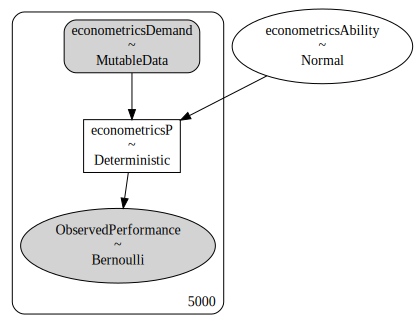

In [13]:
gv = pm.model_graph.model_to_graphviz(m_ex1)
gv

We can use PyMC's `model_to_graphviz` function to visualize what this probabilistic model looks like. In this diagram, oval-shaped nodes represent probability distributions, while rectangles represent deterministic calculations. Rounded rectangles are the `MutableData` class. Grey nodes are "observed."

The arrows determine a dependence structure or the direction of the flow of information. Within the measurement layouts framework, these arrows designate the presence of a linking function.





### Inference

#### Prior predictive check

Before performing inference, we can do prior predictive checks. Given the priors we've chosen and the meta-features (demands), we generate the data: first we simulate the parameters according to the priors

$$θ^{sim} \sim p(θ),$$

then we simulate the data acording to the sampling distributions given the simulated parameters:

$$y^{sim} \sim p(y | \theta^{sim}).$$

In other words, given the prior distributions of the parameters (i.e., abilities) we simulate the data, i.e. `ObservedPerformance` (see more [here](https://mc-stan.org/docs/2_26/stan-users-guide/prior-predictive-checks.html)). This way we explore whether the simulated data covers the range of the observed data which can tell us which priors are consistent with the data and can help us decide which priors to choose.

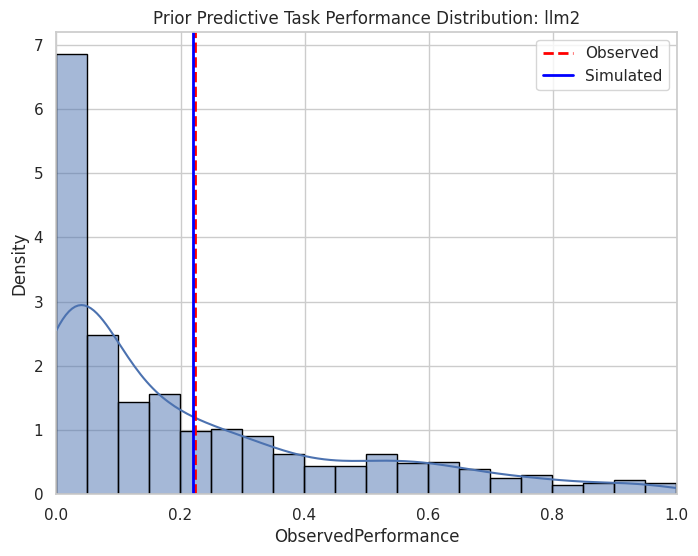

In [14]:
with m_ex1:
    prior_predictive = pm.sample_prior_predictive(samples=1_000)

process_predictive_data_and_plot_histogram(prior_predictive,predictive_type="prior",performance_var_name="ObservedPerformance",LLM=llm)

#### Draw samples from the posterior

In [15]:
with m_ex1:
  inferenceData = pm.sample(3000, tune=2000)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


#### Posterior predictive check

Just like prior predictive checks, where data is simulated from the prior distributions, in this case, data is simulated from the posterior distributions. This tells us how well the model fits the training data.

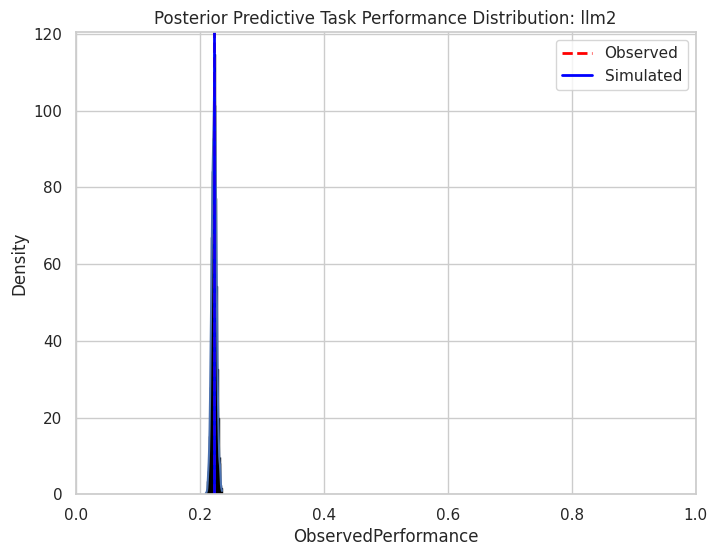

In [16]:
with m_ex1:
  posterior_predictive = pm.sample_posterior_predictive(trace=inferenceData)

process_predictive_data_and_plot_histogram(posterior_predictive,predictive_type="posterior",performance_var_name="ObservedPerformance",LLM=llm)

With our model m, we let PyMC infer the most likely values for the capabilities that we have based on the meta-features and the agent's performance.

We can plot the distribution that we PyMC finds for the capability

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


<Axes: title={'center': 'econometricsAbility'}>

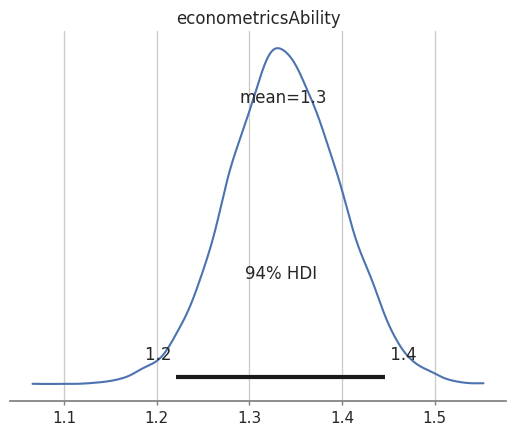

In [17]:
az.plot_posterior(inferenceData["posterior"][["econometricsAbility"]])


As we can see, PyMC has inferred that the agent's `econometricsAbility` is centred around 1.3, with 94% HDI between 1.2 and 1.4.

But how do we know if these inferences are reasonable? In the next section we will explore this.




###Model Diagnostics

PyMC is powerful and intuitive enough that we can straightforwardly design measurement layouts. But how do we know if the data are appropriate for them, or whether there are any issues with how they were fitted? There are several diagnostics we can run on measurement layouts, of which some of the most useful are presented here.

First, we can look at the traces for each of the capabilities. Below, we can visualise the traces. For each chain, there is a posterior distribution (see the left plot). We want them to look relatively similar to each other, as this means that each chain converged to a similar posterior. On the right, we see a time series plot indicating how often each of the values were sampled in the chain. We want there to be relative homogeneity here, suggesting that all values were sampled a similar number of times. Note, depending on the prior, there might be spikes for certain values (if, for instance, the prior is a Cauchy distribution or something similarly heavy-tailed).

array([[<Axes: title={'center': 'econometricsAbility'}>,
        <Axes: title={'center': 'econometricsAbility'}>]], dtype=object)

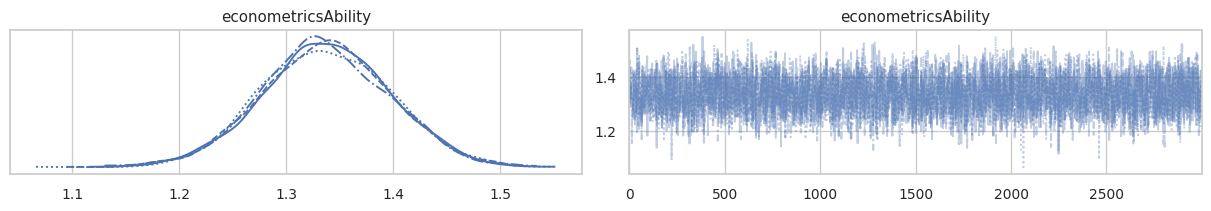

In [19]:
plt.rcParams['figure.constrained_layout.use'] = True
az.plot_trace(inferenceData["posterior"][["econometricsAbility"]])

A second diagnostic is an energy plot, which also enables us to check whether the MCMC algorithm (usually, as here, NUTS) has explored the full posterior distribution. In the energy plot, we simply want the distribution of marginal energy during sampling, and distribution of energy transitions between steps (see [here](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html#model-checking) and [here](https://arxiv.org/abs/160400695)), to overlap and look similar. Everything looks good for our agents with the simple measurement layout:

<Axes: >

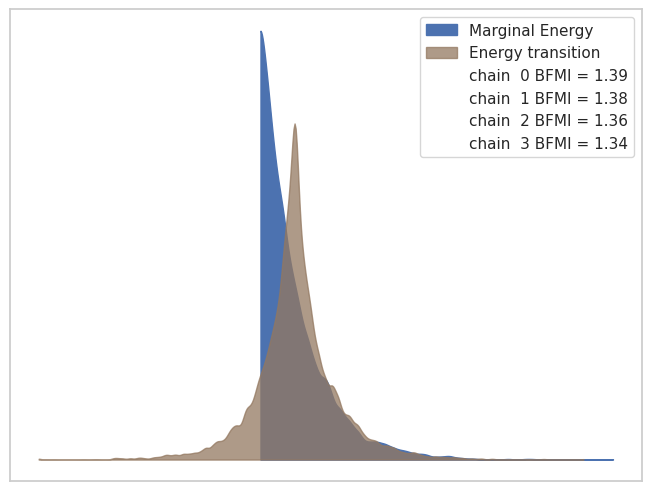

In [20]:
az.plot_energy(inferenceData)

BFMI stands for Bayesian Fraction of Missing Information and measures the mismatch between two distributions. Empirically, BFMI values below 0.3 have been shown to be problematic. (see Chapter 6.1 [here](https://arxiv.org/pdf/1701.02434.pdf)).

In the literature on Bayesian statistics, several convergence diagnostics have been proposed. [Vehtari et al. (2021)](https://projecteuclid.org/journals/bayesian-analysis/volume-16/issue-2/Rank-Normalization-Folding-and-Localization--An-Improved-R%cb%86-for/10.1214/20-BA1221.full) present a comprehensive overview. Two diagnostics that we can use out of the box to gauge the convergence of multiple chains when fitting a measurement layout are $\hat{R}$
 and Effective Sample Size (ESS).

 $\hat{R}$ is, roughly, the ratio of the variance mixed across all chains compared to the root mean squared variance of the variance in each individual chain. If the chains are not converging, then the between-chain variance should be higher than the within-chain variance, so values higher than 1 indicate lack of convergence. In practice, Vehtari et al. suggest values higher than 1.01 indicate a lack of convergence. Below, we present $\hat{R}$
 for both navigation and visual capabilities.

ESS is, roughly, "how many independent draws contain the same information as the dependent sample obtained by the MCMC algorithm. The higher the ESS the better" [(Vehtari et al., 2021, p. 672)](https://projecteuclid.org/journals/bayesian-analysis/volume-16/issue-2/Rank-Normalization-Folding-and-Localization--An-Improved-R%cb%86-for/10.1214/20-BA1221.full). We can distinguish between $ESS_{bulk}$
 and $ESS_{tail}$
 too, where the latter is the ESS in the tails of the posterior distribution, outside of the credibility interval. This is especially useful if credibility intervals are to be used downstream in inference. Below, note that the sample size for each chain is 5000 (2000 warm up/burn-in, 3000 sample; unless you have changed it).

In [21]:
az.summary(inferenceData["posterior"][["econometricsAbility"]])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
econometricsAbility,1.337,0.06,1.221,1.446,0.001,0.001,5281.0,8227.0,1.0


### Predict performance on the test data

Another way that we can test the inferences of the measurement layout is by using it to predict overall performance on an unseen test set. This is similar in nature to the train-test split that is common in ML.

We have a test set prepared and we've loaded it as `ex2_1_test_data`.

We will also need to define a function that will do the prediction for us. This will leverage PyMC's sample_posterior_predictive function.

In [22]:
# Make predictions after training a measurement layout
def predict(m, trace, relevantData, var_name:str):
    with m:
        predictions = pm.sample_posterior_predictive(trace, var_names=[var_name], return_inferencedata=False,
                                                     predictions=True, extend_inferencedata=False)
        predictionChainRuns = predictions[var_name][:, :, 0:len(relevantData)]
        predictionsInstance = np.mean(predictionChainRuns, (0, 1))

    return predictionsInstance

To use the predictions we create a new model with the test data in as meta-features. We then pass it to the predict function along with the learnt trace of the inferred data because this is where the distributions for each capability are kept.

In [23]:
m_test = setupModel(ex2_1_test_data,llm=llm)

predictions = predict(m_test, inferenceData, ex2_1_test_data, "ObservedPerformance")

#### Brier Score and AUROC

Now that we have our predictions we want to evaluate how good they were on our test-set. As our model is predicting probabilities of success we can use the [**Brier score**](https://en.wikipedia.org/wiki/Brier_score) as a metric for understanding how good our model is at predicting performance.

The Brier score is defined as follows
$$Brier Score = \frac{1}{N} \sum_{i=1}^N(f_i - o_i)^2 $$

Where:
$N$ is the number of items in the test set. $f_i$ is the prediction made by the model for the $i$th element, and $o_i$ is the actual outcome for the $i$th element.

That is, at its core Brier scoreis the mean squared error applied to probabilities. It calculates the squared difference between the probability of success for a task and whether the LLM actually succeeded on the tasks (represented as 1 for success and 0 for failure). It measures the accuracy of probabilistic predictions.

To use the Brier score, we can use `brier_score_loss` from `sklearn.metrics`.

**AUROC** (Area Under the Receiver Operating Characteristic curve) is another useful metric. It is used to evaluate the performance of a binary classifier as the classification threshold is varied. ROC curve plots the true positive rate against the false positive rate for each classification threshold. AUROC is the area under that curve. In effect, it's the probability a randomly-chosen positive example is ranked more highly than a randomly chosen negative example. It's a measure of correct ordering of the classification. We can use `roc_auc_score` from `sklearn.metrics` to calculate the AUROC.

 AUROC vs Brier score example (taken from [here](https://medium.com/@penggongting/understanding-roc-auc-pros-and-cons-why-is-bier-score-a-great-supplement-c7a0c976b679)):



 Assume a classifier predicts these probabilities \[0.5, 0.3, 0.8, 0.4, 0.2\] and the actual outcomes were \[0, 1, 1, 0, 0\]. Let's load this into a data frame.

In [24]:
df_example = pd.DataFrame({'Y_pred': [0.5, 0.3, 0.8, 0.4, 0.2], 'Y_actual':[0, 1, 1, 0, 0]})

#Let's sort the data by Y_pred
df_example.sort_values(by='Y_pred',ascending = False)

,Y_pred,Y_actual
2,0.8,1
0,0.5,0
3,0.4,0
1,0.3,1
4,0.2,0


What AUROC outputs is the probability that any of the randomly chosen 1's appears above a 0 in the above sorted data frame. There are 3 zeros and 2 ones = 6 pairs of 1s and 0s. In the above example the top 1 appears higher than all three 0s and the next 1 appears higher in rank than only one of the 0s. So AUROC is 4/6, i.e. 0.667.

Using the `roc_auc_score` function from `sklearn`  we get the same result:

In [25]:
example_roc_auc = roc_auc_score(df_example['Y_actual'], df_example['Y_pred'])
example_roc_auc

0.6666666666666667

Let's also calculate the brier score.

In [27]:
example_brier_score = brier_score_loss(df_example['Y_actual'], df_example['Y_pred'])
example_brier_score

0.196

Let's now change the prediction probabilities, but keep the order!

In [28]:
df_example_new = pd.DataFrame({'Y_pred': [0.97, 0.5, 0.99, 0.9, 0.01], 'Y_actual':[0, 1, 1, 0, 0]})

#Let's sort the data by Y_pred
df_example_new.sort_values(by='Y_pred',ascending = False)

,Y_pred,Y_actual
2,0.99,1
0,0.97,0
3,0.90,0
1,0.50,1
4,0.01,0


In [29]:
example_roc_auc_new = roc_auc_score(df_example_new['Y_actual'], df_example_new['Y_pred'])
example_roc_auc_new

0.6666666666666667

The AUROC is exactly the same! However, the Brier score is very different:

In [30]:
example_brier_score_new = brier_score_loss(df_example_new['Y_actual'], df_example_new['Y_pred'])
example_brier_score_new

0.40022000000000013

So in short, AUROC indicates how well the classifier has ranked the predictions. The Brier Score tells us how accurate those probabilistic predictions are.

#### Get Brier Score and AUROC for the measurement layout

In [31]:
brier_score_mes_lay = brier_score_loss(ex2_1_test_data[llm+'_success'], predictions)
roc_auc_mes_lay = roc_auc_score(ex2_1_test_data[llm+'_success'], predictions)

In [38]:
print(f'Brier Score measurement layout for {llm}:',brier_score_mes_lay)
print(f'AUROC measurement layout for {llm}:',roc_auc_mes_lay)

Brier Score measurement layout for llm2: 0.15621609277083334
AUROC measurement layout for llm2: 0.7237406802282769


Here we (hopefully!) see that the Brier Score and AUROC are decent (definitely lower than 0.25 for Brier score and higher than 0.5 for AUROC). This corresponds to a good prediction.

But how good is this compared to what we could achieve with alternative methods?






### Comparison to XGBoost
Let's compare the predictive power of the measurement layouts to XGBoost.
First we will need to import the relevant libraries



In [33]:
from xgboost import XGBClassifier

In [34]:
ex2_1_training_data.head()

,llm1_success,llm2_success,llm3_success,econometrics_difficulty
0,0,0,0,7
1,0,0,0,6
2,0,0,0,6
3,0,0,1,1
4,0,1,1,2


In [35]:
inputFeatures = ["econometrics_difficulty"]
outputFeature = llm+'_success'

XTrain=ex2_1_training_data[inputFeatures]
yTrain=ex2_1_training_data[outputFeature]

XTest = ex2_1_test_data[inputFeatures]
yTest = ex2_1_test_data[outputFeature]

We assign the meta-features to input Features and the observed success as an output feature before collecting all of the examples in the training set together as XTrain and YTrain.

In [36]:
model = XGBClassifier(objective='binary:logistic')

model.fit(XTrain, yTrain)
# Make predictions on the test data
yPredictions = model.predict_proba(XTest)[:, 1]  # Get the probabilities for the positive class

brier_score_xgb = brier_score_loss(yTest, yPredictions)
roc_auc_xgb = roc_auc_score(yTest, yPredictions)

In [37]:
print(f'Brier Score XGBoost for {llm}:',brier_score_xgb)
print(f'AUROC XGBoost for {llm}:',roc_auc_xgb)

Brier Score XGBoost for llm2: 0.1555149765381359
AUROC XGBoost for llm2: 0.7239707980486009


The Brier score achieved for XGBoost should be similar to the one for the Measurement Layout.

This is a positive result! The measurement layouts allow for high predictive power while also providing *explanatory* power. We can extract capabilities to help us understand what is driving the performance on the benchmark that we've recorded. But we don't have to sacrifice predictive power to do so. Later, when we have more then one capability, we will see how the measurement layouts approach can be even more useful.

## Exercise 1.2

In this exercise, I'd like to ask you to learn the econometrics capabilities for the other two LLMs. Remember that the measurement layout model for the other two LLMs is the same except for the performance data. So you can use the `setupModel` function and just change the `llm` part.

As a reminder, this the model:

In [39]:
def setupModel(relevantData,llm:str):

  m_ex1 = pm.Model()

  with  m_ex1:
    #demands
    econometricsDemand = pm.MutableData("econometricsDemand", relevantData["econometrics_difficulty"])

    #abilities
    econometricsAbility = pm.Normal("econometricsAbility", mu = 0, sigma = 4)

    #local performance
    econometricsP = pm.Deterministic("econometricsP", logistic_general(margin(econometricsAbility,econometricsDemand),min=1,max=7*1.2,c=0,p=0.99))

    observed = pm.Bernoulli("ObservedPerformance", econometricsP, observed =relevantData[llm+'_success'])

  return m_ex1


Complete this for loop:

In [ ]:
# some lists to store dictionaries posteriors, convergence metrics, and scores
llms = ['llm1','llm2','llm3']

for llm in llms:
  pass
  # instantiate the model

  #optional: plot prior predictive

  #sample from the posterior

  #optional: plot posterior predictive

  # Plot the trace plot, i.e. chains

  # plot energy plots

  # store relevant metrics: posterior mean, hdi_3, hdi_97, ess_bulk, ess_tail, r_hat; all these can be found by running az.summary

  # instantiate the model with test data

  # make predictions

  # calculate the Brier score and AUROC and store them





llm1


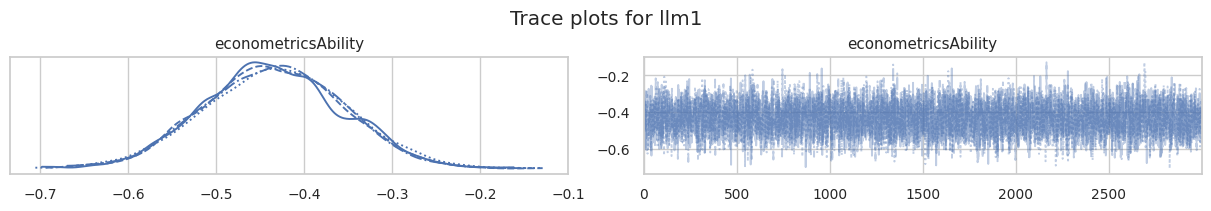

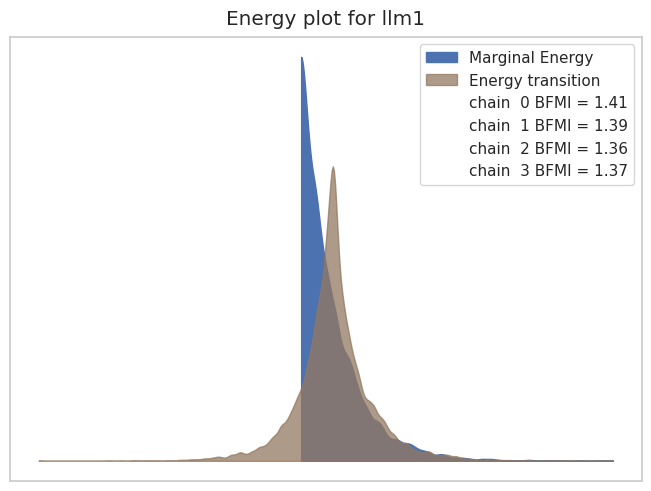

                      mean     sd  hdi_3%  hdi_97%  ess_bulk  ess_tail  r_hat
econometricsAbility -0.435  0.079  -0.583    -0.29  5572.112  7825.348    1.0


{'BrierScore': 0.07765503028472222, 'AUROC': 0.7494493392070485}

llm2


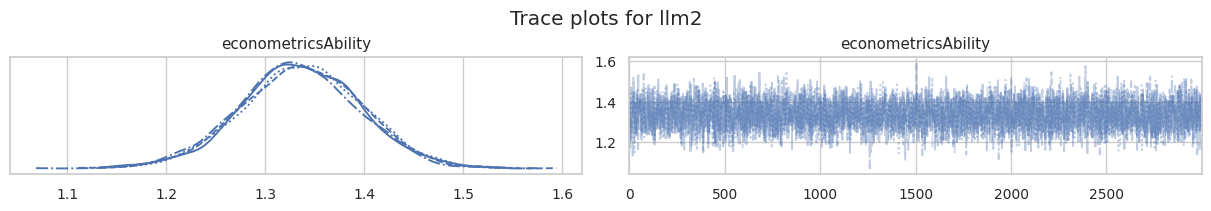

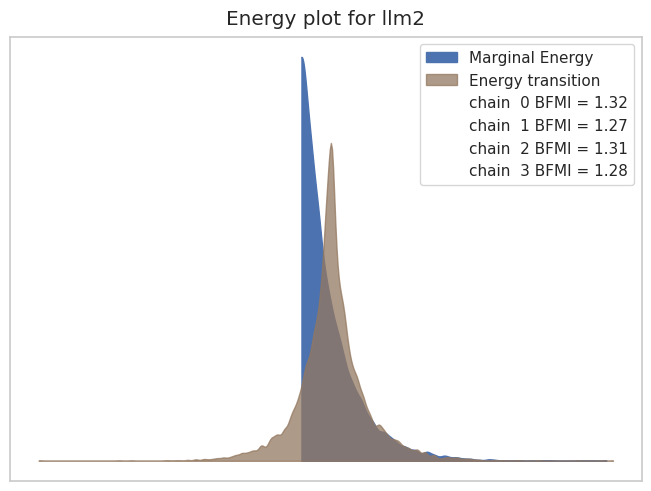

                      mean     sd  hdi_3%  hdi_97%  ess_bulk  ess_tail  r_hat
econometricsAbility  1.336  0.061    1.22    1.451  4840.952  7854.379  1.001


{'BrierScore': 0.15610247564583335, 'AUROC': 0.7285904132916052}

llm3


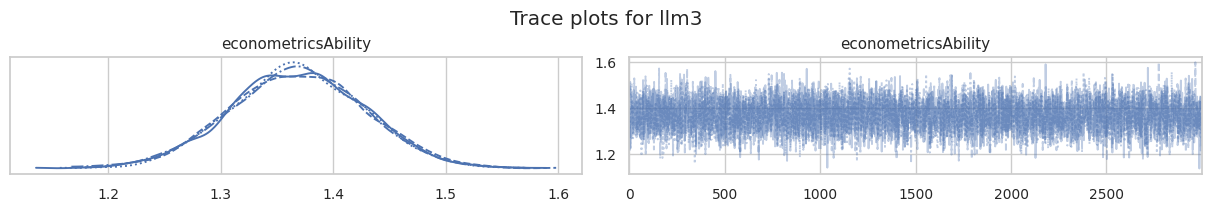

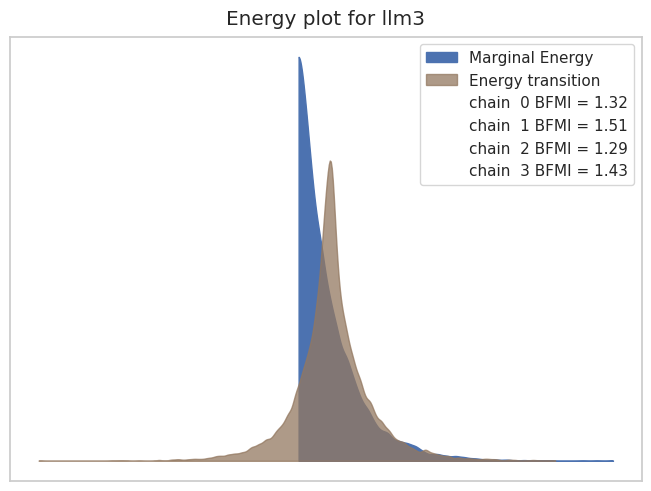

                      mean    sd  hdi_3%  hdi_97%  ess_bulk  ess_tail  r_hat
econometricsAbility  1.368  0.06   1.255     1.48  5654.045  8397.186  1.001


{'BrierScore': 0.17739745884722222, 'AUROC': 0.5985353234571578}


In [40]:
# @title Example solution: Measurement layouts for each llm

scores_dict = {}
metrics_dict = {}
probabilities = {}
abilities = ['econometricsAbility']
predictive_methods_df_mes_lay = pd.DataFrame()
llms = ['llm1','llm2','llm3']

for llm in llms:
    print(f'\n{llm}')

    m_ex1 = setupModel(ex2_1_training_data,llm=llm)

    #sample from the posterior
    with m_ex1:
      inferenceData_new = pm.sample(3000, tune=2000)

    # Plot the trace plot on the first subplot
    axes = az.plot_trace(data=inferenceData_new['posterior'][abilities])
    fig = axes.ravel()[0].figure
    fig.suptitle(f"Trace plots for {llm}")
    plt.show()

    axes = az.plot_energy(data=inferenceData_new)
    fig = axes.figure
    fig.suptitle(f"Energy plot for {llm}")
    plt.show()

    #Collect relevant metrics
    metrics_dict[llm] = {}

    for ability in abilities:

        summary = az.summary(inferenceData_new['posterior'][ability], round_to=3)

        metrics_dict[llm][ability] = {
                'mean': summary['mean'][0],
                'hdi_3%': summary['hdi_3%'][0],
                'hdi_97%': summary['hdi_97%'][0],
                'ess_bulk': summary['ess_bulk'][0],
                'ess_tail': summary['ess_tail'][0],
                'r_hat': summary['r_hat'][0],
        }
        print(summary[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']])

    m_test = setupModel(ex2_1_test_data,llm=llm)

    predictions = predict(m_test, inferenceData_new, ex2_1_test_data, "ObservedPerformance")

    probabilities[llm] = predictions

    brier_score_mes_lay = brier_score_loss(ex2_1_test_data[llm+'_success'], predictions)
    roc_auc_mes_lay = roc_auc_score(ex2_1_test_data[llm+'_success'], predictions)


    scores_dict[llm] = {'BrierScore': brier_score_mes_lay, 'AUROC':roc_auc_mes_lay}
    print(scores_dict[llm])

    predictive_methods_df_mes_lay = pd.concat([predictive_methods_df_mes_lay, pd.DataFrame({"predictive_method": 'Measurement layout', "llm": llm, "BrierScore": brier_score_mes_lay, "AUROC": roc_auc_mes_lay}, index=[0])])


#### Convergence metrics

In [ ]:
# print out ess_bulk  ess_tail  r_hat for each llm

In [57]:
# @title Example solution: convergence metrics
data_for_df = []
for llm, abilities in metrics_dict.items():
    for ability, metrics in abilities.items():
        row = (llm, ability, metrics.get('ess_bulk'), metrics.get('ess_tail'), metrics.get('r_hat'))
        data_for_df.append(row)

# Creating the DataFrame
df = pd.DataFrame(data_for_df, columns=['LLM', 'Ability', 'ess_bulk', 'ess_tail', 'r_hat'])

# Setting LLM and Ability as the index if desired
df.set_index(['LLM', 'Ability'], inplace=True)

# Display the DataFrame
print(df)

                          ess_bulk  ess_tail  r_hat
LLM  Ability                                       
llm1 econometricsAbility  4638.087  8613.942  1.002
llm2 econometricsAbility  5443.794  8393.721  1.001
llm3 econometricsAbility  5749.195  7951.979  1.000


#### Visualise abilities

In [ ]:
# plot means and HDI for econometricsAbility for each llm

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
<ipython-input-45-ef64736a5d2b>:32: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  g.fig.subplots_adjust(top=0.9)


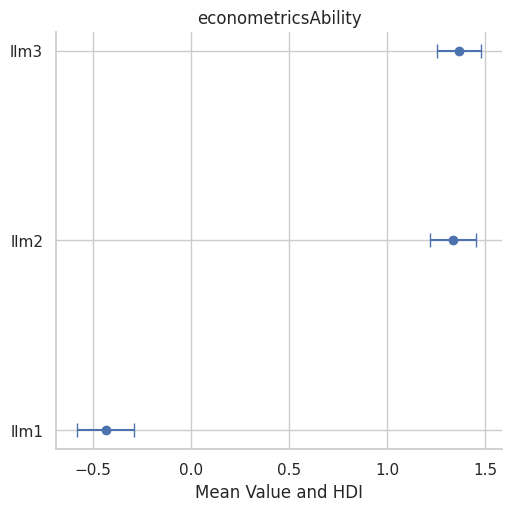

In [45]:
# @title Example solution: plot means and HDI for econometricsAbility for each llm

rows = []
for model, abilities in metrics_dict.items():
    for ability, stats in abilities.items():
        rows.append({
            'LLM': model,
            'Ability': ability,
            'Mean': stats['mean'],
            'Lower': stats['hdi_3%'],
            'Upper': stats['hdi_97%']
        })
df = pd.DataFrame(rows)

# Define a custom plotting function for use with FacetGrid
def plot_with_errorbars(data, **kwargs):
    # Calculate the error terms as positive and negative deviations from the mean
    errors = [data['Mean'] - data['Lower'], data['Upper'] - data['Mean']]
    y_positions = range(len(data))  # Y positions for each LLM

    # Plotting the mean with error bars on the y-axis
    plt.errorbar(data['Mean'], y_positions, xerr=errors, fmt='o', capsize=5, **kwargs)
    plt.yticks(y_positions, data['LLM'])  # Set LLM names as y-ticks

# Create a FacetGrid to plot a separate subplot for each ability
g = sns.FacetGrid(df, col="Ability", sharey=True, height=5, aspect=1)
g.map_dataframe(plot_with_errorbars)

# Adjusting the FacetGrid
g.set_axis_labels("Mean Value and HDI", "")
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.9)

plt.show()

### Compare to XGBoost

In [ ]:
# train XGBoost for each llm

# make predictions on test data

# calculate Brier score and AUROC

In [43]:
# @title Example solution: compare to XGBoost

inputFeatures = ["econometrics_difficulty"]
XTrain=ex2_1_training_data[inputFeatures]
XTest = ex2_1_test_data[inputFeatures]

predictive_methods_df_xgb = predictive_methods_df_mes_lay

for llm in llms:


  outputFeature = llm+'_success'

  yTrain=ex2_1_training_data[outputFeature]
  yTest = ex2_1_test_data[outputFeature]

  model = XGBClassifier(objective='binary:logistic')

  model.fit(XTrain, yTrain)
  # Make predictions on the test data
  yPredictions = model.predict_proba(XTest)[:, 1]  # Get the probabilities for the positive class

  brier_score_xgb = brier_score_loss(yTest, yPredictions)
  roc_auc_xgb = roc_auc_score(yTest, yPredictions)

  predictive_methods_df_xgb = pd.concat([predictive_methods_df_xgb, pd.DataFrame({"predictive_method": 'XGBoost', "llm": llm, "BrierScore": brier_score_xgb, "AUROC": roc_auc_xgb}, index=[0])])

In [ ]:
#print Brier scores and AUROC for measurement layouts and XGBoost

In [44]:
# @title Example solution: print Brier scores and AUROC for measurement layouts and XGBoost

predictive_methods_df_xgb

,predictive_method,llm,BrierScore,AUROC
0,Measurement layout,llm1,0.077655,0.749449
0,Measurement layout,llm2,0.156102,0.728590
0,Measurement layout,llm3,0.177397,0.598535
0,XGBoost,llm1,0.078256,0.748145
0,XGBoost,llm2,0.155515,0.723971
0,XGBoost,llm3,0.158429,0.596094


We find that the econometrics capabilities of LLM2 and LLM3 are very similar, while LLM1's capabilities are significantly lower. This makes sense given the success data. However, we will see how this could change when we start including other capabilities that could affect performance.

We also find that the Brier scores and AUROC are similar for both measurement layouts and XGBoost, implying that we do get enough predictive power from measurement layouts in addition to explainability in terms of capabilities.